In [2]:
#
# Run the hbv parameter estimation with full model
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/hbv_det.m
#

In [29]:
from kipet import KipetModel
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.linalg import eig
import scipy.linalg as sla

In [4]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/hbv_data.csv'
C_data = pd.read_csv(filename, index_col = 0)
C_data.shape

(50, 3)

In [5]:
C_data.head()

,A,B,C
0.000000,1.051482,-0.000739,-0.000501
2.040816,0.718060,2.599459,371.265832
4.081633,0.641247,5.702485,325.080882
6.122449,0.657471,6.944847,296.171685
8.163265,0.772015,9.147780,291.254375


In [6]:
# True parameters
x = np.array([2, 0.025, 1000, 0.25, 1.9985, 7.5E-6])
np.log10(x)

array([ 0.30103   , -1.60205999,  3.        , -0.60205999,  0.30070415,
       -5.12493874])

In [41]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('A', state = 'concentration', init = 1.0)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)

# this initial guess doesn't work
r1.add_parameter('lk1',init = 0.8, bounds=(-6.0, 4.0))
r1.add_parameter('lk2',init = -1.1, bounds=(-6.0, 4.0))
r1.add_parameter('lk3',init = 3.1, bounds=(-6.0, 4.0))
r1.add_parameter('lk4',init = -0.77, bounds=(-6.0, 4.0))
r1.add_parameter('lk5',init = -0.16, bounds=(-6.0, 4.0))
r1.add_parameter('lk6',init = -5.46, bounds=(-6.0, 4.0))

#r1.add_parameter('lk1',init = -1, bounds=(-6.0, 4.0))
#r1.add_parameter('lk2',init = -1, bounds=(-6.0, 4.0))
#r1.add_parameter('lk3',init = -1, bounds=(-6.0, 4.0))
#r1.add_parameter('lk4',init = -1, bounds=(-6.0, 4.0))
#r1.add_parameter('lk5',init = -1, bounds=(-6.0, 4.0))
#r1.add_parameter('lk6',init = -1, bounds=(-6.0, 4.0))


In [42]:
algebraics = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6']

r1.add_algebraic_variables(algebraics)

def rule_algebraics(m, t):
    r = list()
    r.append(pyo.log10(m.Y[t, 'k1']) - m.P['lk1'])
    r.append(pyo.log10(m.Y[t, 'k2']) - m.P['lk2'])
    r.append(pyo.log10(m.Y[t, 'k3'])- m.P['lk3'])
    r.append(pyo.log10(m.Y[t, 'k4']) - m.P['lk4'])
    r.append(pyo.log10(m.Y[t, 'k5']) - m.P['lk5'])
    r.append(pyo.log10(m.Y[t, 'k6']) - m.P['lk6'])
    
    return r

r1.add_algebraics(rule_algebraics)

In [43]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = m.Y[t,'k1']*m.Z[t,'B'] - m.Y[t,'k4']*m.Z[t,'A']
    exprs['B'] = m.Y[t,'k1']*m.Z[t,'A']-m.Y[t,'k2']*m.Z[t,'B']-m.Y[t,'k6']*m.Z[t,'B']*m.Z[t,'C']
    exprs['C'] = m.Y[t,'k3']*m.Z[t,'A']-m.Y[t,'k5']*m.Z[t,'C']-m.Y[t,'k6']*m.Z[t,'B']*m.Z[t,'C']
    return exprs

r1.add_equations(rule_odes)

In [44]:
r1.set_times(0.0,100.0)

In [45]:
r1.add_dataset('C_data', category = 'concentration', data = C_data)

In [46]:
# sigmas as 1/wts used in the book
r1.variances = {'A':1, 'B':100, 'C':1e4}
r1.settings.collocation.nfe = 50
r1.settings.collocation.ncp = 3
r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
r1.settings.parameter_estimator['solver'] = 'k_aug'
r1.settings.solver.linear_solver = 'ma27'

In [47]:
r1.create_pyomo_model()
r1.model.P.pprint()

Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
0.0 100.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/para

In [48]:
r1.run_opt()

        0.24 seconds required to write file
        0.24 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     6915
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1506

Total number of variables............................:     1815
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
T

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0575067e+06 3.78e+04 1.57e+09  -1.0 2.91e+03   7.9 9.24e-05 1.26e-04f  1
  91r 1.0575067e+06 3.78e+04 9.99e+02   4.6 0.00e+00   7.4 0.00e+00 4.07e-08R  6
  92r 1.0575048e+06 2.10e+04 3.12e+05   4.6 3.77e+07    -  3.31e-01 4.46e-04f  1
  93  1.0493157e+06 2.09e+04 1.19e+03  -1.0 1.72e+04    -  2.08e-02 5.74e-03f  1
  94  4.1992412e+05 2.34e+05 6.56e+07  -1.0 2.07e+04    -  1.00e+00 1.00e+00f  1
  95  3.9040192e+05 4.55e+03 9.15e+16  -1.0 4.78e+03   6.9 5.58e-01 1.00e+00f  1
  96  3.0519598e+05 2.17e+03 8.10e+18  -1.0 4.46e+03   7.4 1.00e+00 1.00e+00f  1
  97  3.3514029e+05 3.88e+02 1.70e+19  -1.0 1.47e+03   8.7 1.00e+00 1.00e+00h  1
  98  3.3824669e+05 3.34e+02 1.40e+19  -1.0 4.47e+02  10.0 3.59e-01 1.46e-01h  1
  99r 3.3824669e+05 3.34e+02 9.99e+02   2.5 0.00e+00   9.5 0.00e+00 2.51e-07R  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 3.3820368e+05 1.16e+02

 184  1.3925060e+05 3.17e+02 2.97e+12  -1.0 4.58e-03  14.8 1.00e+00 1.00e+00h  1
 185  1.3925024e+05 3.17e+02 3.11e+17  -1.0 1.36e+04  14.3 9.34e-07 9.21e-06f  1
 186  1.3924839e+05 3.17e+02 2.46e+18  -1.0 1.25e+05  13.9 1.28e-07 3.90e-05f  2
 187  1.3924192e+05 3.17e+02 2.76e+18  -1.0 3.92e+03  13.4 1.00e+00 1.53e-04f  1
 188r 1.3924192e+05 3.17e+02 1.00e+03   1.0 0.00e+00  12.9 0.00e+00 3.93e-07R  3
 189r 1.3924545e+05 3.15e+02 9.98e+02   1.0 5.49e+03    -  2.10e-02 1.40e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 1.3931506e+05 2.60e+02 9.75e+02   1.0 3.29e+03    -  7.22e-02 2.26e-02f  1
 191r 1.3955617e+05 4.34e+02 9.03e+02   1.0 3.18e+03    -  3.59e-02 7.40e-02f  1
 192r 1.3952959e+05 4.31e+02 9.11e+02   1.0 1.44e+03    -  3.14e-02 5.64e-03f  1
 193r 1.3949445e+05 4.25e+02 8.96e+02   1.0 7.86e+02    -  2.37e-02 1.44e-02f  1
 194r 1.3945482e+05 4.16e+02 8.75e+02   1.0 3.46e+02    -  3.19e-02 2.25e-02f  1
 195r 1.3942577e+05 4.06e+02

 297r 1.3751493e+05 1.68e+00 1.63e+03  -1.2 2.62e-02   1.8 1.00e+00 2.88e-02h  1
 298r 1.3751472e+05 1.68e+00 8.29e+02  -1.2 8.26e-02   1.4 1.00e+00 1.00e+00f  1
 299r 1.3751364e+05 1.68e+00 1.83e+02  -1.2 5.22e-02   0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300r 1.3751039e+05 1.68e+00 8.90e+01  -1.2 1.57e-01   0.4 1.00e+00 1.00e+00f  1
 301r 1.3750074e+05 1.68e+00 7.81e+00  -1.2 4.70e-01  -0.1 1.00e+00 1.00e+00f  1
 302r 1.3747200e+05 1.68e+00 2.72e+01  -1.2 1.40e+00  -0.5 1.00e+00 1.00e+00f  1
 303r 1.3738466e+05 1.68e+00 1.05e+03  -1.2 4.18e+00  -1.0 1.00e+00 1.00e+00f  1
 304r 1.3712637e+05 2.99e+00 1.69e+03  -1.2 1.22e+01  -1.5 1.00e+00 1.00e+00f  1
 305r 1.3712538e+05 3.75e+00 4.10e+02  -1.2 1.22e+01  -0.2 9.22e-02 6.84e-02h  4
 306r 1.3712489e+05 4.77e+00 2.71e+03  -1.2 1.70e+01   0.3 4.15e-02 5.20e-02f  1
 307r 1.3712463e+05 5.24e+00 4.65e+02  -1.2 1.30e+01   0.7 1.16e-02 5.91e-02h  3
 308r 1.3712459e+05 5.36e+00

 434r 1.3486494e+05 1.68e+00 2.02e+01  -1.9 2.99e-01   0.6 1.00e+00 1.00e+00f  1
 435r 1.3481763e+05 1.68e+00 4.78e+01  -1.9 8.92e-01   0.1 1.00e+00 1.00e+00f  1
 436r 1.3476832e+05 1.68e+00 1.17e+02  -1.9 2.64e+00  -0.4 1.00e+00 3.19e-01f  1
 437r 1.3475437e+05 1.68e+00 8.10e+02  -1.9 7.30e+00  -0.8 1.00e+00 2.03e-02f  1
 438r 1.3469679e+05 1.68e+00 6.22e+02  -1.9 2.48e+00  -0.4 1.00e+00 3.01e-01f  1
 439r 1.3453977e+05 1.68e+00 1.24e+03  -1.9 4.67e+00  -0.9 9.21e-01 1.50e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r 1.3421925e+05 1.68e+00 3.04e+04  -1.9 1.63e+00  -0.5 1.00e+00 1.00e+00f  1
 441r 1.3422163e+05 1.68e+00 4.46e+03  -1.9 2.99e-02   1.8 1.00e+00 8.44e-01h  1
 442r 1.3422172e+05 1.68e+00 3.15e+03  -1.9 1.52e-02   3.1 4.36e-01 2.92e-01h  1
 443r 1.3422222e+05 1.68e+00 6.33e+02  -1.9 1.42e-02   2.6 1.00e+00 1.00e+00f  1
 444r 1.3422223e+05 1.68e+00 8.38e+02  -1.9 1.65e-02   3.9 6.18e-01 1.27e-01f  1
 445r 1.3422223e+05 1.68e+00

 572r 1.3182221e+05 1.68e+00 4.71e+02  -2.8 2.19e-02   1.6 1.00e+00 3.84e-02h  1
 573r 1.3182036e+05 1.68e+00 2.22e+02  -2.8 5.68e-02   1.1 1.00e+00 7.59e-01f  1
 574r 1.3181308e+05 1.68e+00 3.17e+00  -2.8 1.73e-01   0.6 1.00e+00 1.00e+00f  1
 575r 1.3179131e+05 1.68e+00 3.15e+01  -2.8 5.17e-01   0.1 1.00e+00 1.00e+00f  1
 576r 1.3172620e+05 1.68e+00 2.66e+02  -2.8 1.55e+00  -0.3 1.00e+00 1.00e+00f  1
 577r 1.3162915e+05 1.68e+00 2.42e+02  -2.8 4.64e+00  -0.8 4.32e-01 4.94e-01f  1
 578r 1.3162900e+05 1.68e+00 3.73e+02  -2.8 2.13e-01   0.5 1.00e+00 1.69e-02h  1
 579r 1.3160209e+05 1.68e+00 3.72e+02  -2.8 4.78e-01   0.0 4.58e-01 9.91e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r 1.3159413e+05 1.68e+00 9.67e+01  -2.8 1.82e-01   0.5 1.00e+00 7.76e-01f  1
 581r 1.3157902e+05 1.68e+00 9.05e+01  -2.8 5.44e-01  -0.0 3.27e-01 4.91e-01f  1
 582r 1.3148642e+05 6.64e+01 2.48e+04  -2.8 8.16e+00  -0.5 6.75e-01 8.21e-01f  1
 583r 1.3148241e+05 6.09e+01

 710r 1.2960652e+05 1.68e+00 7.43e+02  -2.8 1.01e+02  -2.0 7.32e-02 1.54e-02f  1
 711r 1.2960646e+05 1.68e+00 1.79e+03  -2.8 5.29e-02   1.2 9.82e-01 3.08e-02h  1
 712r 1.2960134e+05 1.68e+00 1.92e+03  -2.8 1.78e-01   0.7 1.79e-01 1.00e+00f  1
 713r 1.2958642e+05 1.68e+00 1.03e+02  -2.8 4.93e-01   0.2 1.00e+00 9.51e-01f  1
 714r 1.2954770e+05 1.68e+00 2.82e+02  -2.8 1.47e+00  -0.2 3.26e-01 8.19e-01f  1
 715r 1.2951258e+05 1.68e+00 7.44e+02  -2.8 4.41e+00  -0.7 1.00e+00 2.55e-01f  1
 716r 1.2947599e+05 7.42e+00 1.48e+03  -2.8 2.31e+01  -1.2 8.95e-03 6.51e-02f  1
 717r 1.2947432e+05 1.68e+00 9.47e+02  -2.8 7.15e-02   1.0 2.07e-01 1.00e+00h  1
 718r 1.2947160e+05 1.68e+00 2.79e+02  -2.8 2.29e-01   0.6 1.00e+00 3.57e-01f  1
 719r 1.2946904e+05 1.68e+00 3.51e+03  -2.8 8.61e-02   1.0 2.60e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720r 1.2946102e+05 1.68e+00 8.74e+01  -2.8 2.58e-01   0.5 1.00e+00 1.00e+00f  1
 721r 1.2945802e+05 1.68e+00

 848r 1.2895312e+05 1.68e+00 7.99e+02  -2.8 7.30e-01  -0.1 5.52e-01 5.97e-01f  1
 849r 1.2895301e+05 1.68e+00 1.19e+03  -2.8 2.92e-01   2.2 4.19e-02 9.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850r 1.2895303e+05 1.68e+00 1.41e+03  -2.8 2.99e-01   1.7 1.38e-01 5.03e-02h  1
 851r 1.2895304e+05 1.68e+00 1.38e+03  -2.8 2.13e-01   3.9 2.65e-04 2.53e-03h  4
 852r 1.2895303e+05 1.68e+00 1.38e+03  -2.8 4.28e-01   4.4 8.81e-03 1.97e-03f  1
 853r 1.2895307e+05 1.68e+00 1.88e+03  -2.8 9.56e-02   3.9 1.13e-03 3.71e-02h  1
 854r 1.2895307e+05 1.68e+00 1.76e+03  -2.8 9.74e-02   3.4 9.83e-03 5.03e-03h  1
 855r 1.2895307e+05 1.68e+00 1.76e+03  -2.8 6.45e-02   4.7 2.44e-03 3.96e-04f  1
 856r 1.2895313e+05 1.68e+00 1.07e+04  -2.8 9.44e-02   4.2 8.76e-03 5.66e-02h  1
 857r 1.2895313e+05 1.68e+00 1.07e+04  -2.8 3.23e-02   3.8 1.19e-01 6.80e-03h  1
 858r 1.2895327e+05 1.68e+00 9.00e+03  -2.8 8.61e-02   3.3 5.32e-02 1.59e-01h  1
 859r 1.2895362e+05 1.68e+00

 940r 1.2852733e+05 1.68e+00 1.25e+02  -2.8 1.65e-01   0.3 1.00e+00 6.40e-01h  1
 941r 1.2833671e+05 2.61e+00 1.30e+03  -2.8 5.78e+03    -  1.81e-01 2.21e-02f  1
 942r 1.2833287e+05 1.68e+00 1.20e+02  -2.8 4.68e-01  -0.2 1.00e+00 8.86e-01h  1
 943r 1.2832156e+05 1.68e+00 3.62e+01  -2.8 1.25e+00  -0.7 1.00e+00 1.00e+00f  1
 944r 1.2829661e+05 1.68e+00 3.33e+02  -2.8 3.14e+00  -1.1 4.10e-01 1.00e+00f  1
 945r 1.2829614e+05 1.68e+00 5.85e+01  -2.8 3.62e-02   1.1 1.00e+00 1.00e+00h  1
 946r 1.2829450e+05 1.68e+00 1.76e+02  -2.8 1.35e-01   0.6 3.01e-01 1.00e+00f  1
 947r 1.2827246e+05 8.13e+01 2.35e+04  -2.8 2.28e+00   0.1 1.00e+00 1.00e+00f  1
 948r 1.2825070e+05 6.87e+01 2.02e+04  -2.8 3.92e+00   0.6 1.22e-01 6.15e-01f  1
 949r 1.2824521e+05 4.07e+01 1.20e+04  -2.8 1.63e+00   0.1 5.92e-03 3.56e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950r 1.2823538e+05 2.92e+01 8.58e+03  -2.8 3.07e+00  -0.4 3.33e-01 2.40e-01f  1
 951r 1.2822770e+05 2.45e+01

1078r 1.2787725e+05 1.29e+01 9.79e+04  -2.8 1.10e-01   5.4 7.86e-04 8.01e-02h  1
1079r 1.2787725e+05 1.09e+01 8.81e+04  -2.8 4.96e-02   5.8 7.18e-01 1.54e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080r 1.2787725e+05 1.24e+01 6.98e+04  -2.8 5.27e-02   5.4 2.19e-01 2.23e-01f  1
1081r 1.2787725e+05 1.31e+01 6.63e+04  -2.8 2.21e-01   4.9 3.80e-03 4.78e-02h  1
1082r 1.2787725e+05 1.41e+01 6.17e+04  -2.8 2.86e-02   5.3 1.00e+00 7.62e-02f  1
1083r 1.2787725e+05 1.65e+01 4.92e+04  -2.8 9.42e-02   4.8 3.87e-01 1.84e-01f  1
1084r 1.2787725e+05 1.65e+01 4.89e+04  -2.8 1.81e-02   5.3 1.00e+00 8.20e-03f  1
1085r 1.2787725e+05 2.59e+01 4.77e+03  -2.8 3.21e-02   4.8 1.00e+00 8.93e-01f  1
1086r 1.2787725e+05 2.58e+01 4.17e+03  -2.8 4.92e-02   4.3 1.00e+00 1.36e-01f  1
1087r 1.2787725e+05 2.58e+01 4.16e+03  -2.8 1.47e-01   3.8 7.19e-01 2.51e-03f  1
1088r 1.2787725e+05 2.58e+01 4.05e+03  -2.8 4.39e-01   3.4 8.38e-01 2.84e-02f  1
1089r 1.2787725e+05 2.58e+01

1216r 1.2881140e+05 1.68e+00 8.95e+02  -6.3 6.36e-01  -0.5 1.00e+00 3.41e-02h  1
1217r 1.2879912e+05 1.68e+00 7.07e+02  -6.3 1.88e+00  -0.9 1.00e+00 1.95e-01f  1
1218r 1.2878988e+05 1.68e+00 6.66e+02  -6.3 5.38e+00  -1.4 5.28e-01 5.62e-02f  1
1219r 1.2878966e+05 1.68e+00 8.01e+02  -6.3 2.66e-01  -0.1 1.00e+00 2.38e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220r 1.2876427e+05 1.68e+00 6.32e+01  -6.3 7.96e-01  -0.6 1.00e+00 9.21e-01f  1
1221r 1.2869025e+05 1.68e+00 2.25e+01  -6.3 2.32e+00  -1.0 1.00e+00 9.53e-01f  1
1222r 1.2867092e+05 1.68e+00 2.16e+01  -6.3 6.39e+00  -1.5 1.26e-01 9.64e-02f  1
1223r 1.2866815e+05 1.68e+00 1.40e+03  -6.3 3.18e-01  -0.2 8.13e-01 2.44e-01h  1
1224r 1.2866814e+05 1.68e+00 1.35e+03  -6.3 9.53e-01  -0.7 4.21e-02 4.58e-04h  1
1225r 1.2866354e+05 1.68e+00 6.72e+01  -6.3 3.58e-01  -0.2 1.00e+00 3.66e-01f  1
1226r 1.2862882e+05 1.68e+00 4.92e+01  -6.3 1.07e+00  -0.7 3.20e-02 9.66e-01f  1
1227r 1.2861527e+05 1.68e+00

1354r 1.2590669e+05 1.68e+00 3.66e+02  -6.3 1.37e+02  -4.0 1.00e+00 9.65e-02f  1
1355r 1.2593427e+05 1.49e+02 6.27e+02  -6.3 2.83e+03  -4.5 1.00e+00 1.19e-01f  1
1356r 1.2593427e+05 1.49e+02 1.68e+03  -6.3 1.28e+02  -3.1 1.00e+00 5.29e-07h  2
1357r 1.2593777e+05 1.12e+01 1.05e+03  -6.3 1.48e+02  -3.6 1.00e+00 9.25e-01h  1
1358r 1.2593773e+05 1.11e+01 1.04e+03  -6.3 1.11e+01  -0.5 9.54e-03 6.47e-03h  1
1359r 1.2593773e+05 1.11e+01 1.04e+03  -6.3 1.10e+01  -1.0 8.23e-04 1.75e-06h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360r 1.2593773e+05 1.11e+01 1.04e+03  -6.3 1.08e+01   0.4 0.00e+00 7.89e-09R  2
1361r 1.2593773e+05 1.11e+01 1.04e+03  -6.3 6.36e+01  -0.1 2.25e-07 1.24e-09f  1
1362r 1.2593773e+05 1.11e+01 1.04e+03  -6.3 2.40e+01  -0.6 6.35e-04 1.75e-06f  1
1363r 1.2593794e+05 1.05e+01 1.02e+03  -6.3 2.41e+01  -1.1 6.38e-02 2.56e-02f  1
1364r 1.2593800e+05 9.99e+00 9.93e+02  -6.3 2.15e+01  -1.5 3.04e-02 2.39e-02f  1
1365r 1.2594058e+05 2.26e+00

1491r 1.4304175e+05 1.03e+02 2.09e+04  -6.3 3.03e+03  -2.5 3.97e-06 7.07e-03f  1
1492r 1.4303578e+05 3.68e+01 1.96e+04  -6.3 2.53e+03  -3.0 1.74e-02 4.10e-02f  1
1493r 1.4303624e+05 3.67e+01 1.96e+04  -6.3 3.16e+02  -2.5 7.68e-02 3.81e-04f  1
1494r 1.4305921e+05 3.69e+01 1.92e+04  -6.3 5.89e+02  -3.0 4.72e-07 2.18e-02f  1
1495r 1.4305921e+05 3.69e+01 1.92e+04  -6.3 1.50e+02  -2.6 1.57e-01 1.99e-07f  1
1496r 1.4315488e+05 1.59e+01 1.59e+04  -6.3 1.29e+02  -3.1 8.43e-07 1.74e-01f  1
1497r 1.4315488e+05 1.59e+01 1.59e+04  -6.3 2.99e+01  -1.7 1.93e-02 5.50e-07f  1
1498r 1.4315946e+05 1.48e+01 1.54e+04  -6.3 2.85e+01  -1.3 1.17e-02 3.37e-02f  1
1499r 1.4317310e+05 1.22e+01 1.40e+04  -6.3 2.49e+01  -1.8 4.02e-02 8.94e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500r 1.4317421e+05 1.20e+01 1.38e+04  -6.3 1.71e+01  -0.4 4.88e-03 1.33e-02f  1
1501r 1.4317432e+05 1.20e+01 1.38e+04  -6.3 2.54e+01  -0.9 2.93e-03 1.04e-03f  1
1502r 1.4317432e+05 1.20e+01

1584r 1.4322397e+05 4.53e+00 5.76e+03  -6.3 3.34e+00   1.9 2.23e-02 3.06e-03f  1
1585r 1.4322365e+05 4.11e+00 5.16e+03  -6.3 4.11e+00   1.4 1.19e-01 9.59e-02f  1
1586r 1.4322345e+05 3.88e+00 4.90e+03  -6.3 4.12e+00   1.0 3.66e-02 5.62e-02f  1
1587r 1.4322346e+05 3.86e+00 4.86e+03  -6.3 4.01e+00   0.5 1.98e-02 5.79e-03f  1
1588r 1.4322330e+05 3.53e+00 1.32e+04  -6.3 3.91e+00   0.9 9.78e-03 7.88e-02f  1
1589r 1.4322326e+05 3.41e+00 1.41e+04  -6.3 3.68e+00   0.4 9.31e-01 3.20e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1590r 1.4322238e+05 1.68e+00 2.66e+03  -6.3 3.41e+00   0.9 1.58e-01 7.93e-01f  1
1591r 1.4322236e+05 1.68e+00 2.81e+03  -6.3 7.50e-01   1.3 1.00e+00 7.26e-02f  1
1592r 1.4322162e+05 1.68e+00 1.60e+03  -6.3 7.04e-01   0.8 1.00e+00 4.32e-01f  1
1593r 1.4322168e+05 1.68e+00 1.47e+03  -6.3 3.94e-01   0.3 1.00e+00 8.41e-02f  1
1594r 1.4322191e+05 1.68e+00 1.27e+03  -6.3 4.73e-01  -0.1 1.00e+00 1.37e-01f  1
1595r 1.4322264e+05 1.68e+00

1721r 1.3935140e+05 1.68e+00 7.07e+02  -9.0 2.72e+01  -3.4 1.00e+00 6.96e-02f  1
1722r 1.3925391e+05 4.79e+00 4.25e+02  -9.0 6.32e+01  -3.9 1.00e+00 3.99e-01f  1
1723r 1.3913572e+05 3.26e+01 1.74e+02  -9.0 1.08e+02  -4.4 1.00e+00 5.92e-01f  1
1724r 1.3928942e+05 5.40e+01 3.46e+02  -9.0 1.41e+02  -4.9 1.00e+00 6.11e-01f  1
1725r 1.3949777e+05 2.26e+01 8.08e+04  -9.0 7.04e+01  -4.5 1.00e+00 7.49e-01f  1
1726r 1.3951059e+05 6.68e+00 2.02e+04  -9.0 9.09e+00  -3.1 1.00e+00 7.02e-01f  1
1727r 1.3952462e+05 4.72e+00 1.42e+04  -9.0 1.06e+01  -3.6 1.00e+00 2.98e-01h  1
1728r 1.3962709e+05 2.74e+00 4.90e+03  -9.0 2.72e+01  -4.1 1.00e+00 7.01e-01f  1
1729r 1.3998712e+05 8.41e+00 1.33e+03  -9.0 5.27e+01  -4.6 1.00e+00 8.95e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730r 1.4083567e+05 1.59e+01 1.90e+03  -9.0 7.15e+01  -5.0 1.00e+00 1.00e+00h  1
1731r 1.4187473e+05 1.41e+01 2.17e+05  -9.0 1.65e+02  -5.5 1.00e+00 6.68e-01h  1
1732r 1.4187580e+05 1.33e+01

1811r 1.8056079e+05 3.74e+00 1.10e+05  -9.0 6.44e+02   0.1 8.30e-05 1.85e-03f  1
1812r 1.8056084e+05 3.17e+00 1.10e+05  -9.0 1.46e+03  -0.3 2.03e-04 4.11e-04f  2
1813r 1.8056138e+05 2.33e+00 1.10e+05  -9.0 6.46e+02   0.1 1.85e-05 1.37e-03f  1
1814r 1.8056140e+05 1.79e+00 1.10e+05  -9.0 1.21e+03  -0.4 1.07e-04 4.45e-04f  1
1815r 1.8056157e+05 1.68e+00 1.10e+05  -9.0 5.55e+02   0.0 9.35e-04 9.65e-04f  1
1816r 1.8056160e+05 1.68e+00 1.07e+05  -9.0 7.52e+02  -0.4 1.62e-03 2.49e-04f  2
1817r 1.8056161e+05 1.68e+00 1.06e+05  -9.0 3.46e+02  -0.0 1.64e-11 2.39e-04f  1
1818r 1.8056135e+05 1.68e+00 1.06e+05  -9.0 4.22e+02  -0.5 1.59e-04 2.60e-04f  1
1819r 1.8056140e+05 1.68e+00 1.05e+05  -9.0 2.98e+02  -0.1 2.79e-04 6.86e-04f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820r 1.8056150e+05 1.68e+00 9.48e+04  -9.0 1.68e+02   0.4 9.25e-10 3.47e-03f  1
1821r 1.8056154e+05 1.68e+00 9.39e+04  -9.0 2.18e+01  -0.1 1.49e-03 2.26e-03f  1
1822r 1.8056151e+05 1.68e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950r 2.1938518e+05 1.68e+00 2.88e+04  -9.0 1.05e-02   0.7 1.87e-01 1.82e-01f  1
1951r 2.1938518e+05 1.68e+00 2.84e+04  -9.0 1.93e-02   0.2 9.34e-01 5.30e-02f  1
1952r 2.1938518e+05 1.68e+00 2.70e+04  -9.0 5.77e-02  -0.3 1.00e+00 4.96e-02f  1
1953r 2.1938523e+05 1.68e+00 1.74e+04  -9.0 2.44e-02  -0.7 1.00e+00 3.55e-01f  1
1954r 2.1938531e+05 1.68e+00 1.45e+04  -9.0 6.83e-02  -1.2 1.00e+00 1.70e-01f  1
1955r 2.1938543e+05 1.68e+00 1.17e+04  -9.0 1.94e-01  -1.7 1.00e+00 1.08e-01f  1
1956r 2.1938596e+05 1.68e+00 9.28e+03  -9.0 5.39e-01  -2.2 1.00e+00 2.28e-01f  1
1957r 2.1938719e+05 1.68e+00 7.30e+03  -9.0 1.38e+00  -2.6 1.00e+00 2.31e-01f  1
1958r 2.1938798e+05 1.68e+00 1.23e+03  -9.0 4.30e-01  -3.1 1.00e+00 8.33e-01f  1
1959r 2.1938807e+05 1.68e+00 1.20e+03  -9.0 1.32e+00  -3.6 1.00e+00 3.47e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960r 2.1939142e+05 1.68e+00

NameError: name 'm' is not defined

In [38]:
print("The estimated parameters are:")
r1.results.show_parameters

The estimated parameters are:

The estimated parameters are:
lk1 3.0082076269084266
lk2 2.0156024568460023
lk3 4.0
lk4 4.0
lk5 1.3215983013617927
lk6 -5.050187605609664


In [39]:
{k: 10**x for (k, x) in r1.results.P.items()}

{'lk1': 1019.0784712463421,
 'lk2': 103.65791207790326,
 'lk3': 10000.0,
 'lk4': 10000.0,
 'lk5': 20.969993766208923,
 'lk6': 8.908660205867059e-06}

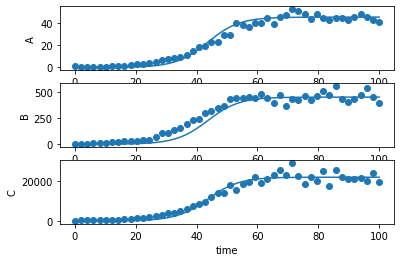

In [40]:
fig, ax = plt.subplots(3)
cmplist = ['A', 'B', 'C']
for (i, c) in enumerate(cmplist):
    ax[i].scatter(r1.results.Cm.index, r1.results.Cm[c])
    ax[i].plot(r1.results.Z.index, r1.results.Z[c])
    ax[i].set_xlabel('time')
    ax[i].set_ylabel(c)

In [ ]:
# since kipet outputs reduced hessian which equals covariance if right sigma values are specified. 
# since we just specified sigma=1, we need to adjust the covariance matrix output from KIPET to get the 
# estimated covariance matrix
mse = r1.results.objective / (C_data.shape[0]*3 - 6)
cov_est = 2 * mse * r1.results.parameter_covariance
cov_est

In [ ]:
eigval, eigvec = sla.eig(cov_est)
eigval, eigvec

In [ ]:
eigvec[:,4]

In [ ]:
dof = C_data.shape[0]*3 - 6
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_est))
conf_delta, conf_delta / np.abs(np.array(list(r1.results.P.values())))